In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

C:\Users\AURIMASSilva\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('fourGreta.csv')
df['UpOrDown'] = df['returns'].apply(lambda x : 1 if x > 0 else 0)

---

# Modelling with returns and sentiment 

In [3]:
# get the values in form of numpy matrix
sentiment = df['sentiment'].values
returns = df['returns'].values
upordown = df['UpOrDown'].values
assert len(sentiment) == len(returns) == len(upordown)

In [4]:
# scale returns to -1, 1
sc = MinMaxScaler(feature_range = (-1,1))
sc.fit(returns.reshape(-1,1))
returns = sc.transform(returns.reshape(-1,1))
returns = returns.reshape(1,-1)[0]

In [5]:
# Engineer data for time series modelling 
data_gen = TimeseriesGenerator(np.append(sentiment,0.00), np.append(sentiment,0.00),
                                       length = 12, sampling_rate=1,
                                       batch_size=1)

# get features and targets from generated batches
features_sentiment = []
targets_sentiment = []
i = 0
while True:
    try:
        features_sentiment.append(list(data_gen[i][0][0]))
        targets_sentiment.append(data_gen[i][1][0])
        i += 1
    except:
        break
data_gen = TimeseriesGenerator(np.append(returns,0.00), np.append(upordown,0.00),
                                       length= 12, sampling_rate=1,
                                       batch_size=1)

# get features and targets from generated batches
features_returns = []
targets_returns = []
i = 0
while True:
    try:
        features_returns.append(list(data_gen[i][0][0]))
        targets_returns.append(data_gen[i][1][0])
        i += 1
    except:
        break
        
assert len(features_sentiment) == len(features_returns)
assert len(targets_sentiment) == len(targets_returns)

In [6]:
#stack sentiment and return/price data together
full_stack = []
for i in range(len(features_sentiment)):
    combined_stack = []
    for ii in range(len(features_sentiment[0])):
        combined_stack.append([features_sentiment[i][ii], features_returns[i][ii]])
    full_stack.append(combined_stack)

In [7]:
# convert full features and targets into numpy arrays
features = np.array(full_stack)
targets = np.array(targets_returns)
assert len(targets) == len(features)

In [8]:
#assert the target features are engineered correctly
sum(targets[-32:] == df['UpOrDown'][-32:].values) == len(targets[-32:])

True

In [9]:
# get the training, validation and testing sets
x_test, y_test = features[-32:], targets[-32:]
x_hold, y_hold = features[:-32], targets[:-32]



x_train, x_valid = x_hold[:int(len(x_hold)*.9)], x_hold[int(len(x_hold)*.9):]
y_train, y_valid = y_hold[:int(len(y_hold)*.9)], y_hold[int(len(y_hold)*.9):]

assert len(x_train) + len(x_valid) == len(x_hold)
assert len(y_train) + len(y_valid) == len(y_hold)

In [10]:
# reshape data for keras inputs
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 2)
x_valid = x_valid.reshape(x_valid.shape[0],x_valid.shape[1], 2)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 2)

In [11]:
model = Sequential()
model.add(GRU(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
print('GRU Model Summary')
model.summary()

GRU Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
# optimizer
optim = Adam(lr = 0.005)

In [13]:
# compile model with binary_crossentropy loss
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
filepath = "C:\\Users\\AURIMASSilva\\Desktop\\BTC\\memes\\strategyreturns.hdf5"
checkpoint = [
    ModelCheckpoint(filepath, monitor = 'val_acc', verbose =1, save_best_only=True, mode= 'max')]
#callbacks_list = [checkpoint]                           



model.fit(x_train, y_train, batch_size = 1, epochs = 20, validation_data =(x_valid, y_valid),
          verbose = 2, callbacks = checkpoint, shuffle= False, class_weight= {1: 0.44, 0: 0.54} )

Train on 1361 samples, validate on 152 samples
Epoch 1/20
 - 9s - loss: 0.3361 - acc: 0.5320 - val_loss: 0.6941 - val_acc: 0.4539

Epoch 00001: val_acc improved from -inf to 0.45395, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\strategyreturns.hdf5
Epoch 2/20
 - 9s - loss: 0.3356 - acc: 0.5408 - val_loss: 0.6978 - val_acc: 0.4605

Epoch 00002: val_acc improved from 0.45395 to 0.46053, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\strategyreturns.hdf5
Epoch 3/20
 - 9s - loss: 0.3349 - acc: 0.5320 - val_loss: 0.6933 - val_acc: 0.4934

Epoch 00003: val_acc improved from 0.46053 to 0.49342, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\strategyreturns.hdf5
Epoch 4/20
 - 8s - loss: 0.3350 - acc: 0.5305 - val_loss: 0.6967 - val_acc: 0.4803

Epoch 00004: val_acc did not improve
Epoch 5/20
 - 8s - loss: 0.3353 - acc: 0.5312 - val_loss: 0.6955 - val_acc: 0.5066

Epoch 00005: val_acc improved from 0.49342 to 0.50658, saving model to C:\Users\AURIMASSilva\Desktop\BT

In [15]:
# evaluate classifier results
y_hat = list(map(lambda x : 1 if x >= 0.5 else 0, model.predict(x_test).reshape(1,-1)[0]))
acc_s = accuracy_score(y_test,y_hat)
cm = confusion_matrix(y_test,y_hat)
cm_nice = pd.DataFrame({'Actual Positive': [str(cm[0][0]) + ' (True Positive)',  
                      str(cm[1,0]) + ' (False Negative)'], 'Actual Negative' : 
                        [str(cm[0][1]) + ' (False Positive)', str(cm[1][1]) + ' (True Negative)']})
cm_nice.index = ['Predicted Positive', 'Predicted Negative']

print('Accuracy score (test_set): %s'%acc_s)
print('Confusion Matrix (test_set):')
print(cm_nice)

Accuracy score (test_set): 0.65625
Confusion Matrix (test_set):
                       Actual Negative     Actual Positive
Predicted Positive  5 (False Positive)  15 (True Positive)
Predicted Negative   6 (True Negative)  6 (False Negative)


In [30]:
y_hat_new = model.predict(x_test).reshape(1,-1)[0]

In [17]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_hat_new)

In [18]:
roc_auc = metrics.auc(fpr, tpr)

Area under ROC curve: 0.5833333333333333


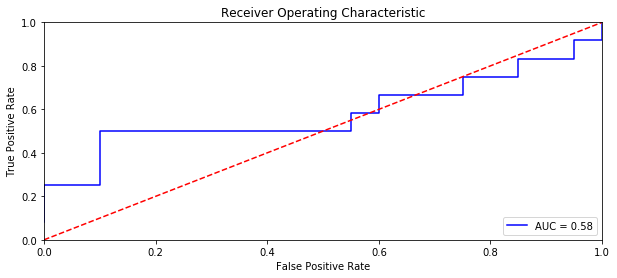

In [19]:
print('Area under ROC curve: %s'%(metrics.roc_auc_score(y_test,y_hat_new)))
plt.figure(figsize=(10,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
kek = pd.DataFrame({'GRUBTCRTN' : np.array(y_hat)})

In [29]:
kek.to_csv('data1.csv', index = False)

In [31]:
y_hat

[0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0]

In [34]:
sum(y_test)

12.0